In [33]:
import keras
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from keras.layers import Conv1D, Conv2D, Dense, Input, Concatenate, Reshape, Lambda
from keras.models import load_model
from keras.utils import plot_model
from scipy import stats as ss
from scipy import optimize
from scipy.interpolate import griddata
from IPython.display import Image, display

import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
from itertools import product

In [7]:
def create_model(grid_size, n_dense_layers, dense_1_scaling, depth, kernel_size, n_kernels):
    out_dense_2 = (grid_size + kernel_size - 1) // n_dense_layers
    n_samples_new = out_dense_2 * n_dense_layers - kernel_size + 1
    
    if n_samples_new != grid_size:
        print("grid_size adjusted from", grid_size, "to", n_samples_new)
        grid_size = n_samples_new
    else:
        print("parameters match for grid size", grid_size)

    model = Input(shape=(2,), name='input')
    print("Shape after input:", model.shape)

    layer_1 = []
    layer_2 = []
    reshape = []
    
    for i in range(n_dense_layers):
        layer_1.append(Dense(dense_1_scaling * depth, activation='relu', name='dense_level_1_{:02d}'.format(i))(model))
        layer_2.append(Dense(out_dense_2 * depth, activation='relu', name='dense_level_2_{:02d}'.format(i))(layer_1[-1]))
        reshape.append(Reshape(target_shape=(out_dense_2, depth, 1))(layer_2[-1]))
    
    concat = Concatenate(axis=-1)(reshape)
    print("Shape after concat:", concat.shape)
    
    reshape = Reshape(target_shape=(grid_size + kernel_size - 1, depth, 1))(concat)
    print("Shape after reshape:", reshape.shape)
    
    conv = Conv2D(filters=n_kernels, kernel_size=(kernel_size, depth), strides=1)(reshape)
    
    avg = Lambda(lambda x: K.sum(x, axis=-1), output_shape=lambda s: (s[0], s[1]))(conv)
    print("Shape after avg:", avg.shape)
    
    reshape_after_avg = Reshape(target_shape=(grid_size,))(avg)
    print("Shape after reshape:", reshape.shape)    
    
    model = keras.Model(model, reshape_after_avg)
    
    plot_model(model, show_shapes=True, to_file='model.png')
    display(Image(retina=True, filename='model.png'))
    
    return model, grid_size

In [8]:
def gen_data(n_sampled_params, grid_size):
    mu = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_sampled_params) # TODO Once we use classes, make these attributes.
    sd = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_sampled_params)
    x = np.linspace(MIN_X, MAX_X, grid_size)
    # TODO Make sure that distributions don't get off the grid (truncated).

    params = np.concatenate((mu[..., np.newaxis], sd[..., np.newaxis]), 1)
    x_grid = ss.norm(mu[:, np.newaxis], sd[:, np.newaxis]).logpdf(x[np.newaxis, :])
    
    return params, x_grid

In [52]:
# Define parameter range.
MIN_X, MAX_X = -10, 10
MIN_MU, MAX_MU = -3, 3
MIN_SD, MAX_SD = 0.5, 3

# Data settings.
N_DATA_IN = 100000
grid_size = 100 # May be dynamic, depending on model parameters.

# NN Settings.
N_DENSE_LAYERS = 20
DENSE_1_SCALING = 1
DEPTH = 25
KERNEL_SIZE = 40 # TODO Consider adding this as a fraction of the grid size.
N_KERNELS = 15

# TODO: Loss function plotting; allow for different loss functions.

grid_size adjusted from 100 to 81
Shape after input: (?, 2)
Shape after concat: (?, 6, 25, 20)
Shape after reshape: (?, 120, 25, 1)
Shape after avg: (?, 81, 1)
Shape after reshape: (?, 120, 25, 1)


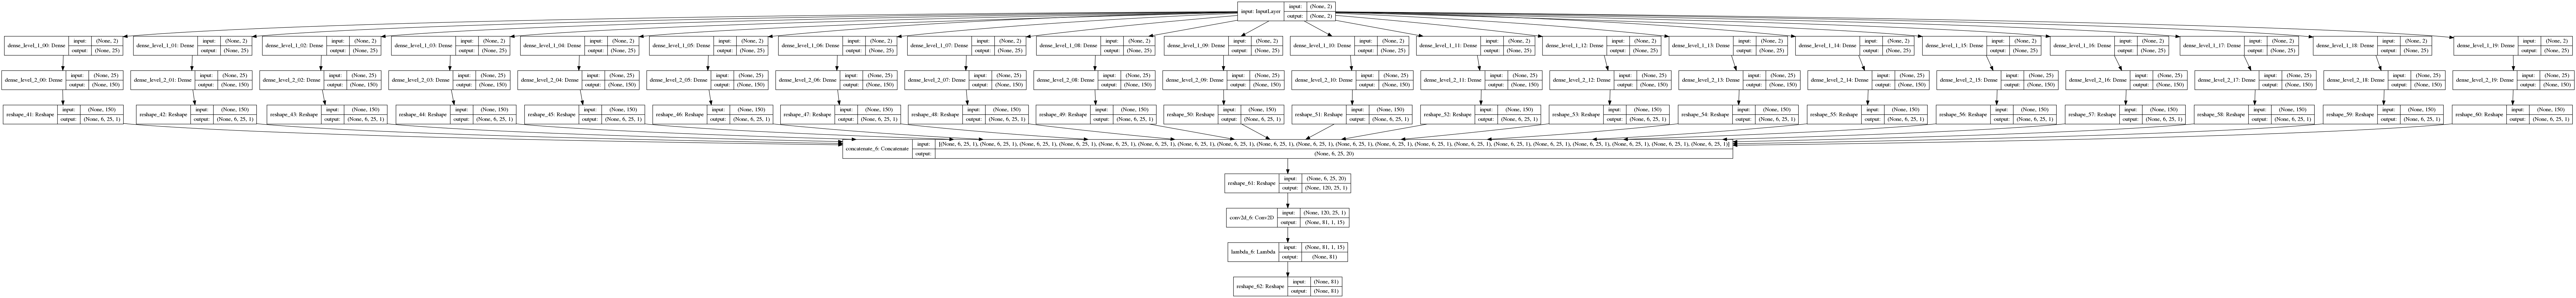

Epoch 1/5
100000/100000 [==============================] - 33s 328us/step - loss: 24.7371
Epoch 2/5
100000/100000 [==============================] - 30s 296us/step - loss: 0.1874
Epoch 3/5
100000/100000 [==============================] - 31s 308us/step - loss: 0.1212
Epoch 4/5
100000/100000 [==============================] - 36s 365us/step - loss: 0.1106
Epoch 5/5
100000/100000 [==============================] - 35s 352us/step - loss: 0.0913


In [53]:
model, grid_size = create_model(grid_size, N_DENSE_LAYERS, DENSE_1_SCALING, DEPTH, KERNEL_SIZE, N_KERNELS)
model.compile(optimizer='adam', loss='mean_squared_error')
params, x_grid = gen_data(N_DATA_IN, grid_size)
model.fit(params, x_grid, shuffle=True, batch_size=32, epochs=5)

In [54]:
# Only use this when we actually trained a good model...
#model.save('model.h5')

In [55]:
predictions = model.predict(params)

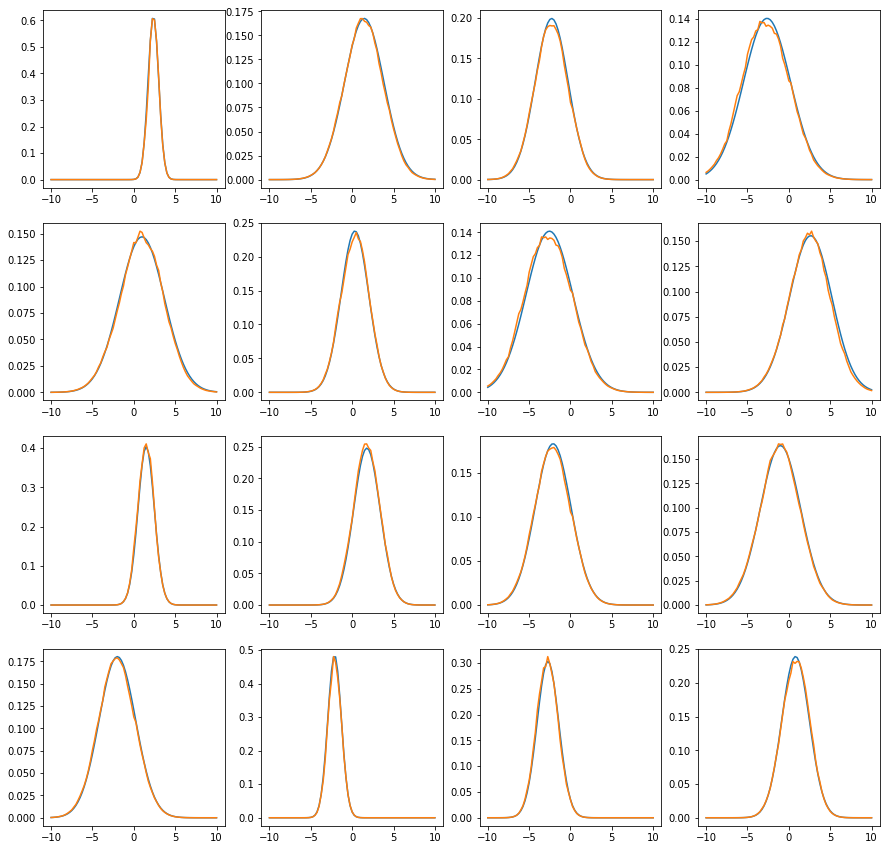

In [56]:
plt.figure(figsize=(15, 15))

for i, ix in enumerate(np.linspace(0, len(predictions), 16, dtype=int, endpoint=False)):
    plt.subplot(4, 4, i + 1)
    
    plt.plot(np.linspace(MIN_X, MAX_X, grid_size), np.exp(x_grid[ix, :]))
    plt.plot(np.linspace(MIN_X, MAX_X, grid_size), np.exp(predictions[ix, :]))

In [57]:
def log_likelihood(model, theta, x_grid, x):
    if np.abs(theta[0]) > MAX_MU or theta[1] < MIN_SD or theta[1] > MAX_SD: # TODO Adjust this accordingly.
        return -1e9
    
    theta = np.atleast_2d(theta)
    likelihood_on_grid = model.predict(theta).T
    
    points = np.atleast_2d(x_grid).T

    ll = griddata(x_grid, likelihood_on_grid, x, fill_value=-1e9)
    
    return ll

In [58]:
def get_summed_ll(model, theta, x_grid, x):
    return np.sum(log_likelihood(model, theta, x_grid, x))

In [59]:
def estimate_mu(model, x_grid, x):
    return optimize.minimize(lambda theta: -get_summed_ll(model, theta, x_grid, x), 
                             x0=[0, 1], 
                             method='Nelder-Mead').x[0:2]

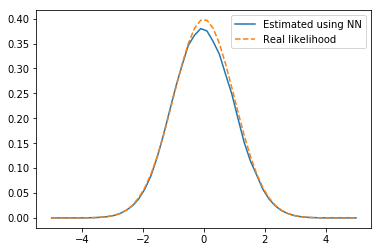

In [60]:
theta = np.array([0, 1]) # Mean 0, SD 1.
test_grid = np.linspace(MIN_X, MAX_X, grid_size)
samples = np.linspace(-5, 5)
ll = log_likelihood(model, theta, test_grid, samples)
    
plt.plot(samples, np.exp(ll), label='Estimated using NN')
plt.plot(samples, ss.norm().pdf(samples), ls='--', label='Real likelihood')
plt.legend()

In [61]:
test_grid = np.linspace(MIN_X, MAX_X, grid_size)
x = ss.norm(0.8, 0.6).rvs(50)
est = estimate_mu(model, test_grid, x)
print('Mu:', est[0], 'Sigma:', est[1])

Mu: 0.6814820420993548 Sigma: 0.5597543346166056


In [62]:
df = []
df1 = []

n_ns = 10
n_runs = 10
n_params = 5

mus = ss.uniform(MIN_MU, MAX_MU - MIN_MU).rvs(n_params)
sigmas = ss.uniform(MIN_SD, MAX_SD - MIN_SD).rvs(n_params)

pars = product(np.linspace(50, 100, n_ns, dtype=int), np.arange(n_runs), zip(mus, sigmas))
test_grid = np.linspace(MIN_X, MAX_X, grid_size)

with tqdm(total=n_ns*n_params*n_runs) as t:
    for n, trial, params in pars:
        test_data = ss.norm(params[0], params[1]).rvs(n)

        params_est = estimate_mu(model, test_grid, test_data)
        mu_estimate = params_est[0]
        sigma_estimate = params_est[1]
        
        ml_mu_estimate = np.mean(test_data)
        ml_sigma_estimate = np.std(test_data)

        df.append({'n':n,
                   'trial':trial,
                   'mu':params[0],
                   'mu_nn':mu_estimate,
                   'mu_ml':ml_mu_estimate})
        
        df1.append({'n':n,
                    'trial':trial,
                    'sigma':params[1],
                    'sigma_nn':sigma_estimate,
                    'sigma_ml':ml_sigma_estimate})
        t.update()
    
df = pd.DataFrame(df)
df1 = pd.DataFrame(df1)

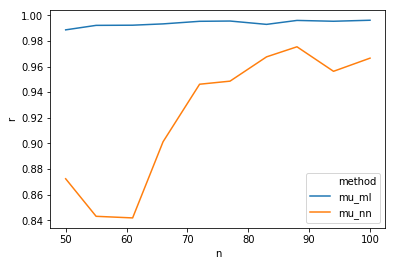

In [63]:
df_ = df.melt(id_vars=['mu', 'n', 'trial'], var_name='method', value_name='estimate')
tmp = df_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['mu'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=tmp.reset_index())

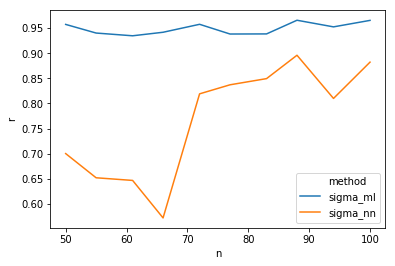

In [64]:
df1_ = df1.melt(id_vars=['sigma', 'n', 'trial'], var_name='method', value_name='estimate')
tmp1 = df1_.groupby(['n', 'method']).apply(lambda d: ss.pearsonr(d['estimate'], d['sigma'])[0]).to_frame('r')
sns.lineplot('n', 'r', 'method', data=tmp1.reset_index())